# Homework 4

We have learned about the basics of using machine learning and deep learning for many computer vision problems. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `pip install torch torchvision` in your environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`. 

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10 (`torchvision.datasets.CIFAR10`), so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

(You may find `torchvision.transforms.Compose` useful to combine transforms like `torchvision.transforms.ToTensor`, `torchvision.transforms.Normalize` and so on)

In [34]:
trainloader = None
testloader = None
batch_size = 64

### YOUR CODE HERE
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class cifar10(torch.utils.data.Dataset):
    def __init__(self, path, transforms=None, height=32, width=32, channel=3):
        self.path = path
        self.transforms = transforms
        self.height = height
        self.width = width
        self.channel = 3
        self.data = None
        self.labels = []
        if os.path.isdir(self.path):
            for file in os.listdir(self.path):
                if file == 'batches.meta' or file == "readme.html" or file == "test_batch":
                    continue
                dict = unpickle(os.path.join(self.path, file))
                if self.data is None:
                    self.data = dict[b'data']
                else:
                    self.data = np.vstack((self.data, dict[b'data']))
                self.labels+=dict[b'labels']
        else:
            dict = unpickle(self.path)
            if self.data is None:
                self.data = dict[b'data']
            else:
                self.data = np.vstack((self.data, dict[b'data']))
            self.labels+=dict[b'labels']
        assert self.data.shape[0] == len(self.labels)
        

    def __getitem__(self, idx):
        raw_data = self.data[idx]
        img_size = self.height*self.width
        assert len(raw_data) == self.channel * img_size

        img = raw_data.reshape(self.channel, self.height, self.width)
        img = img.transpose(1, 2, 0)
        img = torchvision.transforms.ToTensor()(img)
        if not self.transforms is None:
            img = self.transforms(img)
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.labels)

# tfm = transforms.Compose((
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(15),
#     transforms.RandomAdjustSharpness(sharpness_factor=1),
#     transforms.RandomAutocontrast(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ))

train_set = cifar10('./cifar-10-batches-py', transforms=transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = cifar10('./cifar-10-batches-py/test_batch', transforms=transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
### END YOUR CODE 

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's plot out some training images to see what we are dealing with:

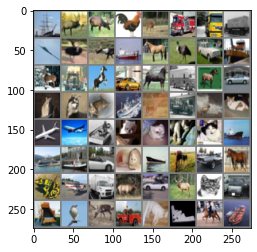

 ship  deer  deer  bird  deer truck truck truck plane  bird  deer  ship horse  bird   car  ship  deer truck horse   car horse truck horse   car   cat   dog   cat  ship  deer truck  deer   cat plane plane  ship   dog   cat   cat   cat  ship  ship  ship   car   cat  ship horse   car horse  frog plane truck  deer   car  deer   cat truck truck  bird  deer truck   dog plane horse  ship


In [35]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output.

In [36]:
from network import Net, resNet
from torchvision import models
from vit import ViT

net = Net().cuda()
# net = resNet().cuda()

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start). 

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [37]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003, weight_decay=1e-5) 

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take several minutes on your CPU.

In [38]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
writer = SummaryWriter()
epoch_num = 20
for epoch in range(epoch_num):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    mini_batchs = 0
    for inputs, labels in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistic1s
        running_loss += loss.item()
        mini_batchs += 1
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
    mean_loss = running_loss / mini_batchs
    print("Epoch %d: Train Loss: %.2f" % (epoch+1, mean_loss))
    writer.add_scalar("Train/Loss", mean_loss, epoch+1)
    
    # eval
    net.eval()
    running_loss = 0
    mini_batchs = 0
    for x, y in tqdm(testloader):
        x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            pred = net(x)
            loss = criterion(pred, y)
            running_loss+=loss.item()
            mini_batchs+=1
    mean_loss = running_loss / mini_batchs
    print("Epoch %d: Eval Loss: %.2f" % (epoch+1, mean_loss))
    writer.add_scalar("Eval/loss", mean_loss, epoch+1)

print('Finished Training')

100%|██████████| 782/782 [00:06<00:00, 122.55it/s]


Epoch 1: Train Loss: 1.73


100%|██████████| 157/157 [00:00<00:00, 186.67it/s]


Epoch 1: Eval Loss: 1.52


100%|██████████| 782/782 [00:05<00:00, 149.84it/s]


Epoch 2: Train Loss: 1.47


100%|██████████| 157/157 [00:00<00:00, 210.58it/s]


Epoch 2: Eval Loss: 1.44


100%|██████████| 782/782 [00:05<00:00, 142.77it/s]


Epoch 3: Train Loss: 1.38


100%|██████████| 157/157 [00:00<00:00, 211.43it/s]


Epoch 3: Eval Loss: 1.38


100%|██████████| 782/782 [00:05<00:00, 135.41it/s]


Epoch 4: Train Loss: 1.33


100%|██████████| 157/157 [00:00<00:00, 200.67it/s]


Epoch 4: Eval Loss: 1.36


100%|██████████| 782/782 [00:05<00:00, 149.75it/s]


Epoch 5: Train Loss: 1.29


100%|██████████| 157/157 [00:00<00:00, 210.00it/s]


Epoch 5: Eval Loss: 1.28


100%|██████████| 782/782 [00:05<00:00, 133.96it/s]


Epoch 6: Train Loss: 1.26


100%|██████████| 157/157 [00:00<00:00, 211.90it/s]


Epoch 6: Eval Loss: 1.27


100%|██████████| 782/782 [00:05<00:00, 134.36it/s]


Epoch 7: Train Loss: 1.23


100%|██████████| 157/157 [00:00<00:00, 199.13it/s]


Epoch 7: Eval Loss: 1.23


100%|██████████| 782/782 [00:05<00:00, 152.94it/s]


Epoch 8: Train Loss: 1.21


100%|██████████| 157/157 [00:00<00:00, 204.77it/s]


Epoch 8: Eval Loss: 1.23


100%|██████████| 782/782 [00:05<00:00, 134.42it/s]


Epoch 9: Train Loss: 1.20


100%|██████████| 157/157 [00:00<00:00, 199.09it/s]


Epoch 9: Eval Loss: 1.22


100%|██████████| 782/782 [00:05<00:00, 134.94it/s]


Epoch 10: Train Loss: 1.18


100%|██████████| 157/157 [00:00<00:00, 209.85it/s]


Epoch 10: Eval Loss: 1.20


100%|██████████| 782/782 [00:05<00:00, 132.55it/s]


Epoch 11: Train Loss: 1.17


100%|██████████| 157/157 [00:00<00:00, 194.87it/s]


Epoch 11: Eval Loss: 1.19


100%|██████████| 782/782 [00:05<00:00, 138.00it/s]


Epoch 12: Train Loss: 1.16


100%|██████████| 157/157 [00:00<00:00, 211.95it/s]


Epoch 12: Eval Loss: 1.20


100%|██████████| 782/782 [00:05<00:00, 139.56it/s]


Epoch 13: Train Loss: 1.15


100%|██████████| 157/157 [00:00<00:00, 210.78it/s]


Epoch 13: Eval Loss: 1.18


100%|██████████| 782/782 [00:05<00:00, 134.86it/s]


Epoch 14: Train Loss: 1.14


100%|██████████| 157/157 [00:00<00:00, 209.58it/s]


Epoch 14: Eval Loss: 1.18


100%|██████████| 782/782 [00:05<00:00, 135.02it/s]


Epoch 15: Train Loss: 1.13


100%|██████████| 157/157 [00:00<00:00, 210.39it/s]


Epoch 15: Eval Loss: 1.17


100%|██████████| 782/782 [00:05<00:00, 135.35it/s]


Epoch 16: Train Loss: 1.12


100%|██████████| 157/157 [00:00<00:00, 209.54it/s]


Epoch 16: Eval Loss: 1.17


100%|██████████| 782/782 [00:05<00:00, 135.04it/s]


Epoch 17: Train Loss: 1.11


100%|██████████| 157/157 [00:00<00:00, 205.11it/s]


Epoch 17: Eval Loss: 1.16


100%|██████████| 782/782 [00:05<00:00, 135.77it/s]


Epoch 18: Train Loss: 1.11


100%|██████████| 157/157 [00:00<00:00, 206.80it/s]


Epoch 18: Eval Loss: 1.17


100%|██████████| 782/782 [00:05<00:00, 133.96it/s]


Epoch 19: Train Loss: 1.10


100%|██████████| 157/157 [00:00<00:00, 211.58it/s]


Epoch 19: Eval Loss: 1.15


100%|██████████| 782/782 [00:05<00:00, 136.14it/s]


Epoch 20: Train Loss: 1.09


100%|██████████| 157/157 [00:00<00:00, 210.04it/s]

Epoch 20: Eval Loss: 1.15
Finished Training


The last step of training is to save the trained model locally to a checkpoint:

In [39]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

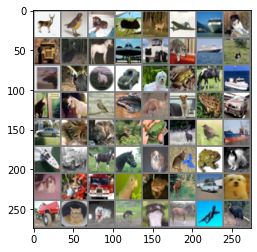

GroundTruth:   deer  bird   dog  bird


In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [41]:
# load in model checkpoint
net = Net()
# net = resNet()

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [42]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE
net.eval()
output = net(images)
predicted = torch.argmax(output, 1)
### END YOUR CODE
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane  bird   dog horse


Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [43]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        ### YOUR CODE HERE
        output = net(images)
        output = torch.argmax(output, 1)
        total += len(labels)
        for predict, true in zip(output, labels):
            if predict==true:
                correct += 1 
        ### END YOUR CODE

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better?

**You answer here:** Write your answer in this markdown cell.

The accuracy is 60% and is much better than random guessing which can only get the accuracy of 10%



Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [44]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # repeat what you did previously, but now for each class
        ### YOUR CODE HERE
        output = net(images)
        output = torch.argmax(output, 1)
        for predict, true in zip(output, labels):
            total_pred[classes[true]] += 1 
            if predict==true:
                correct_pred[classes[predict]] += 1
        ### END YOUR CODE

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 63.5 %
Accuracy for class car   is: 71.6 %
Accuracy for class bird  is: 46.1 %
Accuracy for class cat   is: 42.5 %
Accuracy for class deer  is: 60.3 %
Accuracy for class dog   is: 50.1 %
Accuracy for class frog  is: 70.0 %
Accuracy for class horse is: 65.8 %
Accuracy for class ship  is: 68.4 %
Accuracy for class truck is: 67.6 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not?

**You answer here:** Write your answer in this markdown cell.

baseline：60%

epoch调到40增加到61%，观察loss曲线，发现loss下降速度较慢，且仍维持在较高值，继续增大epoch，准确率最高达到63%；观察loss曲线发现loss在后期下降速度很慢，可能是模型bias导致。

尝试调整优化器为Adam，lr同样设置为1e-3，通过loss曲线观察到loss下降较快，但最终准确率并没有优势；尝试调小lr，并加入weight_decay，增加epochs，准确率提高了1%；

尝试修改模型结构，使用resNet34结构，在同样40个epochs下出现严重过拟合现象，调小epoch到8个，准确率到达69%；通过使用随机翻转、对比度调整等方式扩充数据集抑制过拟合，增加epochs，准确率达到77%。










